<a href="https://colab.research.google.com/github/elly760/AI-projects/blob/main/mindspore_Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTING ALL THE NECESARRY LIBRARIES
from easydict import EasyDict as edict
# the model for dierctory acceas
import os
import numpy as np
import matplotlib.pyplot as plt
import mindspore
import mindspore.dataset as ds
# dataset processing module
from mindspore.dataset.vision import c_transforms as vision
# as image enhancement module
from mindspore import context
# enviroment settin module
import mindspore.nn as nn
# NETWORK MODULE
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig,LossMonitor
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops
# fro common operators
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")






In [ ]:
!wget "https://download.mindspore.cn/models/r1.7/mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt"

In [ ]:
pip install wget

In [ ]:
!wget "https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_train.zip"

--2024-02-23 18:31:37--  https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_train.zip
Resolving proxy.modelarts.com (proxy.modelarts.com)... 192.168.6.3
Connecting to proxy.modelarts.com (proxy.modelarts.com)|192.168.6.3|:80... connected.
Proxy request sent, awaiting response... 200 OK
Length: 226761752 (216M) [application/zip]
Saving to: ‘flower_photos_train.zip’

flower_photos_train 100%[===================>] 216.26M   242MB/s    in 0.9s    

2024-02-23 18:31:38 (242 MB/s) - ‘flower_photos_train.zip’ saved [226761752/226761752]



In [ ]:
!wget "https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_test.zip"

--2024-02-23 18:31:42--  https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos_test.zip
Resolving proxy.modelarts.com (proxy.modelarts.com)... 192.168.6.3
Connecting to proxy.modelarts.com (proxy.modelarts.com)|192.168.6.3|:80... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3006583 (2.9M) [application/zip]
Saving to: ‘flower_photos_test.zip’

flower_photos_test. 100%[===================>]   2.87M  --.-KB/s    in 0.008s  

2024-02-23 18:31:42 (349 MB/s) - ‘flower_photos_test.zip’ saved [3006583/3006583]



In [ ]:
!unzip flower_photos_test.zip

In [ ]:
!unzip flower_photos_train.zip

In [ ]:
cfg = edict({
    'data_path': 'flower_photos_train',# Path of the training dataset
    'test_path':'flower_photos_train',# Path of the test dataset
    'data_size': 3616,
    'HEIGHT': 224, # Image height
    'WIDTH': 224, # Image width
    '_R_MEAN': 123.68, # Average value of CIFAR-10
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_R_STD': 1, # Customized standard deviation
    '_G_STD': 1,
    '_B_STD':1,
    '_RESIZE_SIDE_MIN': 256, # Minimum resize value for image enhancement
    '_RESIZE_SIDE_MAX': 512,
    'batch_size': 32, # Batch size
    'num_class': 5,	# Number of classes
    'epoch_size': 5, # Number of training times
    'loss_scale_num':1024,
    'prefix': 'resnet-ai',   # Name of the model
    'directory': './model_resnet', # Path for storing the model
    'save_checkpoint_steps': 10, # The checkpoint is saved every 10 steps.
})


Number of training datasets:  3616
Number of test datasets:  3618
Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  2


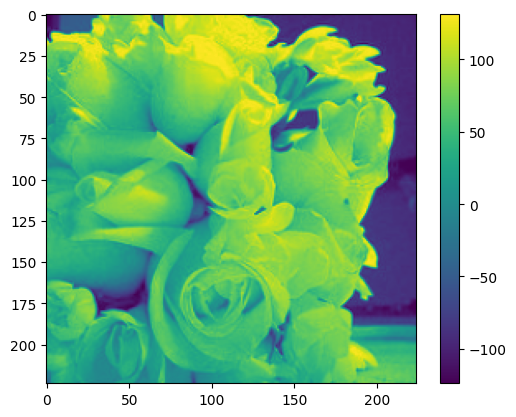

In [ ]:
# Data processing
def read_data(path,config,usage="train"):
    # Read the source dataset of an image from a directory.
    dataset = ds.ImageFolderDataset(path,

    class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4}) # define map operations
    # Operator for image decoding
    decode_op = vision.Decode()
    # Operator for image normalization
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    # Operator for image resizing
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    # Operator for image cropping
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    # Operator for image random horizontal flipping
    horizontal_flip_op = vision.RandomHorizontalFlip()
    # Operator for image channel quantity conversion
    channelswap_op = vision.HWC2CHW()
    # Operator for random image cropping, decoding, encoding, and resizing
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0,
    1.0), max_attempts=100)

    # Preprocess the training set.
    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
        # Preprocess the test set.
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)

    # Preprocess all datasets.
    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)

    # Batch the training set.
    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000) # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
        # Batch the test set.
    else:
        dataset = dataset.batch(1, drop_remainder=True)

    # Data augmentation
    dataset = dataset.repeat(1)

    dataset.map_model = 4
    return dataset


# Display the numbers of training sets and test sets.
de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('Number of training datasets: ',de_train.get_dataset_size()*cfg.batch_size)# get_dataset_size() obtains the batch processing size.
print('Number of test datasets: ',de_test.get_dataset_size())

# Display the sample graph of the training set.
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('Number of channels/Image length/width: ', data_next['image'][0,...].shape)
print('Label style of an image: ', data_next['label'][0]) # Total 5 label classes which are represented by numbers from 0 to 4.

plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()


In [ ]:
import numpy as np
import mindspore.nn as nn
from mindspore import Tensor
import mindspore.ops as ops

def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)

def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)

def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)

def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)

def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)

def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)

class ResidualBlock(nn.Cell):
    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()
        self.expansion = 4
        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)
        self.relu = nn.ReLU()
        self.down_sample = False
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride),
                                                        _bn(out_channel)])

    def construct(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.down_sample:
            identity = self.down_sample_layer(identity)
        out = ops.Add()(out, identity)
        out = self.relu(out)
        return out

class ResNet(nn.Cell):
    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")
        self.layer1 = self._make_layer(block, layer_nums[0], in_channels[0], out_channels[0], strides[0])
        self.layer2 = self._make_layer(block, layer_nums[1], in_channels[1], out_channels[1], strides[1])
        self.layer3 = self._make_layer(block, layer_nums[2], in_channels[2], out_channels[2], strides[2])
        self.layer4 = self._make_layer(block, layer_nums[3], in_channels[3], out_channels[3], strides[3])
        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)
        return out

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        layers = []
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)
        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)
        return nn.SequentialCell(layers)

def resnet50(class_num=5):
    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)
# print("TESTING STAFF")

TESTING STAFF


In [ ]:
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor
from mindspore.common.initializer import Normal
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.model import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig
from mindspore.train.serialization import load_checkpoint

def resnet50(class_num=5):
    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)

# Construct a ResNet-50 network.
net = resnet50(class_num=cfg.num_class)

# Read the parameters of the pre-trained model.
param_dict = load_checkpoint("mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt")

# Display the read model parameters.
print(param_dict)

# Modify the shape corresponding to end_point.weight and end_point.bias by using mindspore.Parameter().
param_dict["features.0.features.0.weight"] = mindspore.Parameter(Tensor(param_dict["features.0.features.0.weight"][:5, :], mindspore.float32), name="variable")
param_dict["features.0.features.0.weight"] = mindspore.Parameter(Tensor(param_dict["features.0.features.0.weight"][:5,], mindspore.float32), name="variable")

# Set the Softmax cross-entropy loss function.
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# Set the learning rate.
train_step_size = de_train.get_dataset_size()
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.001, total_step=train_step_size * cfg.epoch_size, step_per_epoch=train_step_size, decay_epoch=cfg.epoch_size)

# Set the momentum optimizer.
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)

# Smooth the loss value to solve the problem of the gradient being too small during training.
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

# Build the model.
model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})

# Loss value monitoring
loss_cb = LossMonitor(per_print_times=train_step_size)

# Model saving parameters.
ckpt_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1)

# Save the model.
ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=ckpt_config)

# print("============== Starting Training ==============")

# Train the model.
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)  # The training takes 15 to 20 minutes.

# Use the test set to validate the model and output the accuracy of the test set.
metric = model.eval(de_test)
print(metric)


In [ ]:
class_names = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

# Select 10 samples from the test set for testing
for i in range(10):
    test_ = de_test.create_dict_iterator().next()
    test = Tensor(test_['image'], mindspore.float32)

    # Use the model for prediction
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()

    # Show the prediction result
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    print('Prediction result of the ' + str(i) + '-th sample: ', class_names[pre_label], '\tActual result: ', class_names[true_label[0]])
